# Examen Final - Daniel Camargo 24000834

## Problema 1

### Carga y extracción de data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls "/content/drive/MyDrive/Galileo/TM&IR/ExamenFinal"

ExFinal_24000834.ipynb	__MACOSX  tw_source.csv  tw_source.csv.zip


In [4]:
!unzip "/content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/tw_source.csv.zip" -d "/content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/"

Archive:  /content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/tw_source.csv.zip
replace /content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/tw_source.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/tw_source.csv  
replace /content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/__MACOSX/._tw_source.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


### Librerias

In [32]:
import pandas as pd
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud

In [30]:
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [7]:
# guardar data en un dataframe
csv_path = "/content/drive/MyDrive/Galileo/TM&IR/ExamenFinal/tw_source.csv"

column_names = ["id", "timestamp", "query", "user", "text"]
df = pd.read_csv(csv_path, encoding="ISO-8859-1", header=None, names=column_names)

print(df.shape)
df.head()


(1600000, 5)


,id,timestamp,query,user,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### Determinación de los 3 usuarios más populares.

In [8]:
# extraer todas las menciones usando expresiones regulares
mentions = []

for tweet in df["text"].dropna():
    found = re.findall(r"@\w+", tweet)  #encontrar todos los usuarios etiquetados
    mentions.extend(found)

# contar las menciones
mention_counts = Counter(mentions)

# top 3 usuarios más mencionados
top_users = mention_counts.most_common(3)
print("Top 3 usuarios más populares, basado en etiquetas dentro de tweets:")
print(top_users)


Top 3 usuarios más populares, basado en etiquetas dentro de tweets:
[('@mileycyrus', 4500), ('@tommcfly', 3887), ('@ddlovato', 3467)]


Los 3 usuarios mas populares fue el resultado de buscar quienes fueron "tagged" mas veces en los tweets del dataset.

### Armado de Corpus.
#### Content: Tweet; Metadata: ID, Timestamp, Length

In [16]:
# lista de los 3 usuarios más populares
usuarios_populares = ["@mileycyrus", "@tommcfly", "@ddlovato"]
# inicializamos diccionario
corpus_dict = {}

for usuario in usuarios_populares:
    # filtrar tweets que mencionen al usuario
    mask = df["text"].str.contains(re.escape(usuario), case=False, na=False)
    df_usuario = df[mask].copy()

    # calcular longitud
    df_usuario["length"] = df_usuario["text"].str.len()

    # corpus text
    corpus_text = df_usuario["text"].tolist()

    # metadata (id, timestamp, length)
    metadata = df_usuario[["id", "timestamp", "length"]]

    # guardar en diccionario
    corpus_dict[usuario] = {
        "textual": corpus_text,
        "metadata": metadata
    }

    # Mostrar
    print(f"\n{usuario}: {df_usuario.shape[0]} tweets encontrados")
    display(corpus_dict["@mileycyrus"]["metadata"].head(3))


@mileycyrus: 4585 tweets encontrados


,id,timestamp,length
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,107
0,1468286517,Tue Apr 07 00:45:20 PDT 2009,137
0,1468297110,Tue Apr 07 00:49:07 PDT 2009,72



@tommcfly: 3902 tweets encontrados


,id,timestamp,length
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,107
0,1468286517,Tue Apr 07 00:45:20 PDT 2009,137
0,1468297110,Tue Apr 07 00:49:07 PDT 2009,72



@ddlovato: 3492 tweets encontrados


,id,timestamp,length
0,1468063101,Mon Apr 06 23:30:57 PDT 2009,107
0,1468286517,Tue Apr 07 00:45:20 PDT 2009,137
0,1468297110,Tue Apr 07 00:49:07 PDT 2009,72


### Remover Stopwords

In [25]:
# función para remover stopwords
stop_words = set(stopwords.words("english"))

def remove_stopwords(corpus):
    new_corpus = []
    for doc in corpus:
        # pasamos a minúsculas y separamos por espacios
        tokens = doc.lower().split()
        filtered = []
        for w in tokens:
            # eliminamos stopwords
            if w not in stop_words:
                filtered.append(w)
        # unimos de nuevo
        new_doc = " ".join(filtered)
        new_corpus.append(new_doc)
    return new_corpus

In [26]:
# aplicar limpieza de stopwords
for usuario in corpus_dict:
    corpus_dict[usuario]["textual"] = remove_stopwords(corpus_dict[usuario]["textual"])

# prueba
print("@mileycyrus sin stopword:")
print(corpus_dict["@mileycyrus"]["textual"][:5])

@mileycyrus sin stopword:
['@mileycyrus hahaha dont like one time ny got 30 mins sleep got sick love you!!', "@mileycyrus problem, 4:43 here... let's see counting works..1234...56 57 58... 132 133 134... z's me!", '@mileycyrus guess counting sheep work hope get sleep!', '@mileycyrus would meant spending day heaven w/my mom getting see again.', '@mileycyrus awww u seriously cutest dog miley! sorry hope u get sleep! xoxo']


### Stemming y Lemmatization

In [35]:
# inicializar stemmer y lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# función para stemming y lematización
def stem_lemma_corpus(corpus):
    new_corpus = []
    for doc in corpus:
        # separar en palabras
        tokens = doc.split()
        processed = []
        for w in tokens:
            # aplicar stemming / reduce a raíz
            stemmed = stemmer.stem(w)
            # aplicar lematización
            lemmatized = lemmatizer.lemmatize(stemmed)

            # - quitar tokens muy cortos (<=2 letras), solo numéricos o simbolos
            if len(lemmatized) > 2 and lemmatized.isalpha():
                processed.append(lemmatized)

        # reconstruir el documento
        new_doc = " ".join(processed)
        new_corpus.append(new_doc)
    return new_corpus

In [36]:
# aplicar a cada usuario
for usuario in corpus_dict:
    corpus_dict[usuario]["textual"] = stem_lemma_corpus(corpus_dict[usuario]["textual"])

# mostrar ejemplo
print("stemming y lematización de (@mileycyrus):")
print(corpus_dict["@mileycyrus"]["textual"][:5])

stemming y lematización de (@mileycyrus):
['hahaha dont like one time got min sleep got sick love', 'see count', 'guess count sheep work hope get', 'would meant spend day heaven mom get see', 'awww seriou cutest dog sorri hope get xoxo']


### Wordcloud con top 10 por Usuario

In [38]:
# mostrar 10 palabras más frecuentes
def top_palabras(corpus_dict):
    for usuario in corpus_dict:
        # unir todos los tweets procesados en un solo texto
        texto = " ".join(corpus_dict[usuario]["textual"])
        # separar en tokens individuales
        tokens = texto.split()
        # contar frecuencia de palabras
        contador = Counter(tokens)
        # obtener las 10 más comunes
        top10 = contador.most_common(10)
        # mostrar resultados
        print(f"\nTop 10 palabras para {usuario}:")
        for palabra, freq in top10:
            print(f"{palabra}: {freq}")


In [39]:
# Lista de 10 palabras
top_palabras(corpus_dict)


Top 10 palabras para @mileycyrus:
love: 929
miley: 494
vote: 426
come: 319
hope: 305
good: 303
plea: 258
like: 252
see: 250
want: 204

Top 10 palabras para @tommcfly:
love: 480
come: 337
plea: 333
say: 306
tom: 286
good: 245
like: 244
guy: 235
back: 234
see: 221

Top 10 palabras para @ddlovato:
love: 640
come: 331
demi: 317
see: 269
plea: 268
hope: 252
wish: 250
like: 221
wait: 209
want: 190


In [48]:
# función para wordcloud
def mostrar_wordcloud(corpus_dict):
    for usuario in corpus_dict:
        # unir todo el texto
        words = " ".join(corpus_dict[usuario]["textual"]).split()
        freq = Counter(words).most_common(10)
        freq_dict = dict(freq)

        # generar wordcloud con máximo 10 palabras
        wc = WordCloud(width=1000, height=500,
                       background_color="white").generate_from_frequencies(freq_dict)

        # mostrar resultado
        print()
        plt.figure(figsize=(6, 4))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{usuario}")
        plt.show()

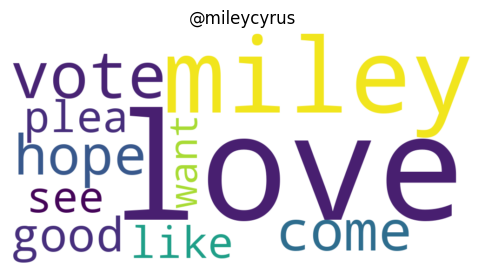

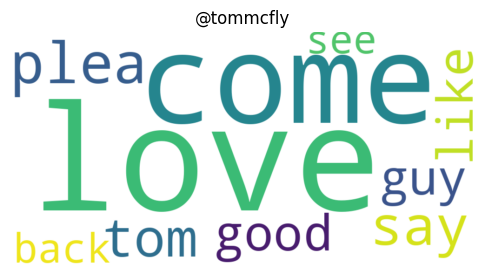

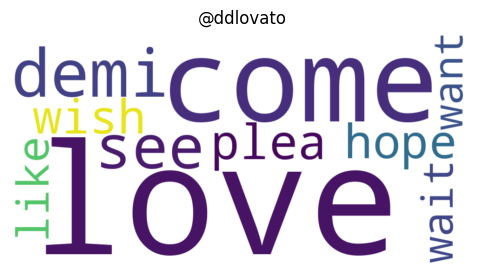

In [49]:
# Mostrar wordcloud
mostrar_wordcloud(corpus_dict)

### ¿Por qué razón citan a los usuarios?  
En el caso de @mileycyrus:  
Las palabras más frecuentes son love, miley, vote, come, hope, good, plea, like, see, want.
Definitivamente los tweets que la mencionan están relacionados con expresiones de cariño ("love", "like"), apoyo directo a Miley (aparece su nombre y "vote"), y mensajes positivos ("hope", "good"). En general, la citan para mostrar admiración, afecto y apoyo en votaciones o actividades.  
  
Para @tommcfly  
Las palabras más frecuentes son love, come, plea, say, tom, good, like, guy, back, see.
Aquí se nota un patrón quizas de interacción personal y muestras de cariño mas directas hacia su persona al usar "love", "guy", "come" teniendo en cuenta que hay referencias directas al nombre "Tom". Parece que hay tendencia en agrado hacia Tom y deseos de verlo o expectativa.  

    
Para @ddlo  
Las palabras más frecuentes son love, come, demi, see, plea, hope, wish, like, wait, want.
En este caso se resalta el nombre Demi, acompañado de términos emocionales como "love", "hope", "wish", "wait". Esto indica que la citan principalmente para expresar admiración, deseos positivos y apoyo personal. Parece que en general se refleja cariño y expectativa hacia su música o su figura o algun otro evento que haya ocurrido en ese tiempo.

## Problema 2

### Parte 1: Dataset

#### Librerias

In [24]:
import os, shutil
import zipfile
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

#### Descarga y descomprensión de archivo (Kaggle)

In [4]:
#---------------------------------------------------------------------------
#***** Descarga automática del dataset desde Kaggle. *****
#***** Si el entorno se reinicia, ejecutar esta celda otra vez. ******
#---------------------------------------------------------------------------

# Download latest version
path = kagglehub.dataset_download("muhriddinmuxiddinov/fruits-and-vegetables-dataset")

print("Path to dataset files:", path)

100%|██████████| 870M/870M [00:39<00:00, 22.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset/versions/2


#### Selección de frutas

In [5]:
# -----------------------------------------------------------------
# Frutas elegidas: FreshApple, FreshBanana, RottenStrawberry.
# Vegetales elegidos: FreshCarrot, FreshTomato, RottenPotato
# -----------------------------------------------------------------

# dataset completo
dataset_path = "/root/.cache/kagglehub/datasets/muhriddinmuxiddinov/fruits-and-vegetables-dataset/versions/2/Fruits_Vegetables_Dataset(12000)"

# carpeta con las 6 clases seleccionadas
selected_path = "/content/dataset_selected"

# Crear carpeta para las clases si no existe
os.makedirs(selected_path, exist_ok=True)

# Clases seleccionadas (con su subcarpeta correspondiente)
selected_classes = [
    ("Fruits/FreshApple", "FreshApple"),
    ("Fruits/FreshBanana", "FreshBanana"),
    ("Fruits/RottenStrawberry", "RottenStrawberry"),
    ("Vegetables/FreshCarrot", "FreshCarrot"),
    ("Vegetables/FreshTomato", "FreshTomato"),
    ("Vegetables/RottenPotato", "RottenPotato")
]

# Copiar carpetas al directorio
for src, dst in selected_classes:
    src_folder = os.path.join(dataset_path, src)
    dst_folder = os.path.join(selected_path, dst)
    # evita duplicados si ya se corrió antes
    if not os.path.exists(dst_folder):
        shutil.copytree(src_folder, dst_folder)

print("Carpetas copiadas en:", os.listdir(selected_path))


Carpetas copiadas en: ['FreshTomato', 'FreshApple', 'FreshBanana', 'RottenStrawberry', 'RottenPotato', 'FreshCarrot']


#### División de data: Train / Validation / Test

In [6]:
# ----------------------------------------------------------
# Se dividirá la data en Train / Val / Test (70-20-10)
# -----------------------------------------------------------

# carpeta con divisiónes
split_dir = "/content/dataset_split"

# Crear carpetas base
for subset in ["train", "val", "test"]:
    os.makedirs(os.path.join(split_dir, subset), exist_ok=True)

# Proporciones
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Iterar sobre cada clase
for class_name in os.listdir(selected_path):
    class_path = os.path.join(selected_path, class_name)
    if not os.path.isdir(class_path):
        continue

    # Crear subcarpetas para esta clase en cada subset
    for subset in ["train", "val", "test"]:
        os.makedirs(os.path.join(split_dir, subset, class_name), exist_ok=True)

    # Obtener todas las imágenes de la clase
    images = os.listdir(class_path)

    # Primero separar train vs temp (val+test)
    train_files, temp_files = train_test_split(images, test_size=(1-train_ratio), random_state=42)
    # Luego separar val vs test
    val_files, test_files = train_test_split(temp_files, test_size=(test_ratio/(val_ratio+test_ratio)), random_state=42)

    # Copiar archivos a cada carpeta
    for f in train_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(split_dir, "train", class_name, f))
    for f in val_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(split_dir, "val", class_name, f))
    for f in test_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(split_dir, "test", class_name, f))

for subset in ["train", "val", "test"]:
    print(f"\nSubset: {subset}")
    subset_dir = os.path.join(split_dir, subset)
    for class_name in os.listdir(subset_dir):
        class_dir = os.path.join(subset_dir, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            print(f"{class_name}: {count} imágenes")



Subset: train
FreshTomato: 422 imágenes
FreshApple: 428 imágenes
FreshBanana: 436 imágenes
RottenStrawberry: 417 imágenes
RottenPotato: 409 imágenes
FreshCarrot: 433 imágenes

Subset: val
FreshTomato: 121 imágenes
FreshApple: 122 imágenes
FreshBanana: 125 imágenes
RottenStrawberry: 119 imágenes
RottenPotato: 117 imágenes
FreshCarrot: 124 imágenes

Subset: test
FreshTomato: 61 imágenes
FreshApple: 62 imágenes
FreshBanana: 63 imágenes
RottenStrawberry: 60 imágenes
RottenPotato: 59 imágenes
FreshCarrot: 63 imágenes


#### Data Augmentation y Preprocesamiento

In [7]:
# Generador de Train
train_datagen = ImageDataGenerator(rescale=1.0/255.0,     # normalización [0,255] -> [0,1]
                                   rotation_range=10,     # rotación en grados
                                   width_shift_range=0.1, # traslación horizontal
                                   height_shift_range=0.1,# traslación vertical
                                   zoom_range=0.1,        # zoom in/out
                                   horizontal_flip=True)  # volteo horizontal

# Generador para Val y Test (solo normalización)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Ruta del dataset dividido
dataset_path = "/content/dataset_split"

# Carga del set de entrenamiento
training_set = train_datagen.flow_from_directory(dataset_path + "/train", # carpeta train
                                                 target_size=(64,64), # redimensionamiento
                                                 batch_size=32,       # cantidad imágenes por batch
                                                 class_mode="categorical", # multiclase
                                                 subset= "training",  # definir datos de entrenamiento
                                                 shuffle=True)

# Carga del set de validación
val_set = test_datagen.flow_from_directory(dataset_path + "/val",      # carpeta Validacion
                                           target_size=(64,64),   # 64x64 pixeles
                                           batch_size=32,         # tamaño de batch
                                           class_mode="categorical", # multiclase
                                           shuffle=False)

# Carga del set de test
test_set = train_datagen.flow_from_directory(dataset_path + "/test",   # carpeta test
                                            target_size=(64,64),  # 64x64 pixeles
                                            batch_size=32,        # tamaño batch
                                            class_mode="categorical", # multiclase
                                            shuffle=False)

# Mostrar clases encontradas
print("Entrenamiento:", training_set.samples)
print("Validación:", val_set.samples)
print("Test:", test_set.samples)
print("Clases:", training_set.class_indices)


Found 2542 images belonging to 6 classes.
Found 728 images belonging to 6 classes.
Found 368 images belonging to 6 classes.
Entrenamiento: 2542
Validación: 728
Test: 368
Clases: {'FreshApple': 0, 'FreshBanana': 1, 'FreshCarrot': 2, 'FreshTomato': 3, 'RottenPotato': 4, 'RottenStrawberry': 5}


### Parte 2: Diseño y Entrenamiento de la Red Neuronal Convolucional

#### Arquitectura

##### Modelo 1

###### Red Convolucional

In [8]:
# ------------------------
# CNN
# ------------------------
cnn_1 = Sequential()

# 1er Capa convolucional
cnn_1.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(64,64,3)))
cnn_1.add(MaxPooling2D(pool_size=(2,2)))

# 2da Capa convolucional
cnn_1.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
cnn_1.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar
cnn_1.add(Flatten())

# Capa densa oculta
cnn_1.add(Dense(units=128, activation="relu"))

# Capa de salida (6 clases)
cnn_1.add(Dense(units=6, activation="softmax"))

# Compilar el modelo
cnn_1.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Resumen del modelo
cnn_1.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

###### Entrenamiento

In [9]:
# -----------------------------
# Entrenamiento
# -----------------------------

history_1 = cnn_1.fit(
    training_set,
    epochs=20,                       # número de épocas
    validation_data=val_set,         # validación en cada época
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
65/80 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.2931 - loss: 1.6551

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 216ms/step - accuracy: 0.3173 - loss: 1.6073 - val_accuracy: 0.5179 - val_loss: 1.2705
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.6543 - loss: 0.9565 - val_accuracy: 0.7747 - val_loss: 0.6430
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 209ms/step - accuracy: 0.7852 - loss: 0.6391 - val_accuracy: 0.8434 - val_loss: 0.5374
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8317 - loss: 0.5488 - val_accuracy: 0.8640 - val_loss: 0.4297
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.8296 - loss: 0.5005 - val_accuracy: 0.8915 - val_loss: 0.3480
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8755 - loss: 0.3648 - val_accuracy: 0.8585 - val_loss: 0.5095
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.8815 - loss: 0.3694 - val_accuracy: 0.9093 - val_loss: 0.3047
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.9153 - loss: 0.2856 - val_accuracy: 0.909

###### Grafica de resultado

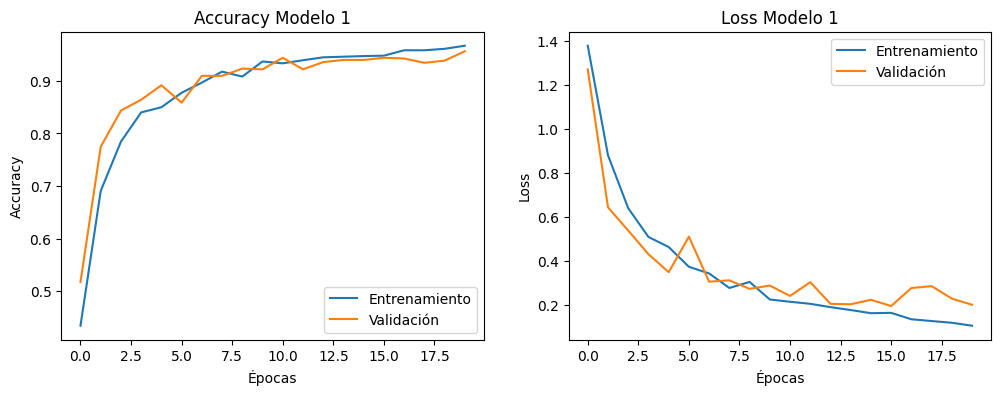


Accuracy validación final (Modelo 1): 0.9560
Loss validación final (Modelo 1): 0.1997

Modelo 1 guardado como cnn_modelo1.h5


In [12]:
# accuracy y loss del modelo 1
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_1.history['accuracy'], label='Entrenamiento')
plt.plot(history_1.history['val_accuracy'], label='Validación')
plt.title('Accuracy Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_1.history['loss'], label='Entrenamiento')
plt.plot(history_1.history['val_loss'], label='Validación')
plt.title('Loss Modelo 1')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

val_acc = history_1.history['val_accuracy'][-1]
val_loss = history_1.history['val_loss'][-1]

print(f"\nAccuracy validación final (Modelo 1): {val_acc:.4f}")
print(f"Loss validación final (Modelo 1): {val_loss:.4f}")

# Guardar modelo entrenado
cnn_1.save("cnn_modelo1.h5")
print("\nModelo 1 guardado como cnn_modelo1.h5")


##### Modelo 2

###### Red CNN

In [13]:
# Modelo 2
cnn_2 = Sequential()

# 1ra Capa convolucional + Pooling
cnn_2.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(64,64,3)))
cnn_2.add(MaxPooling2D(pool_size=(2,2)))

# 2da Capa convolucional + Pooling
cnn_2.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
cnn_2.add(MaxPooling2D(pool_size=(2,2)))

# 3ra Capa convolucional + Pooling
cnn_2.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
cnn_2.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar
cnn_2.add(Flatten())

# Capa densa oculta
cnn_2.add(Dense(units=256, activation="relu"))

# Capa de salida (6 clases)
cnn_2.add(Dense(units=6, activation="softmax"))

# Compilar el modelo
cnn_2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Resumen del modelo
cnn_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,274,694 (4.86 MB)

 Trainable params: 1,274,694 (4.86 MB)

 Non-trainable params: 0 (0.00 B)

###### Entrenamiento

In [14]:
# Entrenar el modelo 2
history_2 = cnn_2.fit(
    training_set,
    epochs=20,
    validation_data=val_set,
    verbose=1
)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - accuracy: 0.3130 - loss: 1.5687 - val_accuracy: 0.5508 - val_loss: 1.1873
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.6466 - loss: 0.9565 - val_accuracy: 0.7404 - val_loss: 0.7589
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.7465 - loss: 0.7514 - val_accuracy: 0.7885 - val_loss: 0.5875
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 177ms/step - accuracy: 0.8284 - loss: 0.5076 - val_accuracy: 0.8434 - val_loss: 0.4698
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8726 - loss: 0.3916 - val_accuracy: 0.9093 - val_loss: 0.2838
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.8747 - loss: 0.3661 - val_accuracy: 0.8984 - val_loss: 0.3166
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 216ms/step - accuracy: 0.9095 - loss: 0.2760 - val_accuracy: 0.9258 - val_loss: 0.3187
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 185ms/step - accuracy: 0.9313 - loss: 0.2109 - val_accu

###### Grafica y resultados

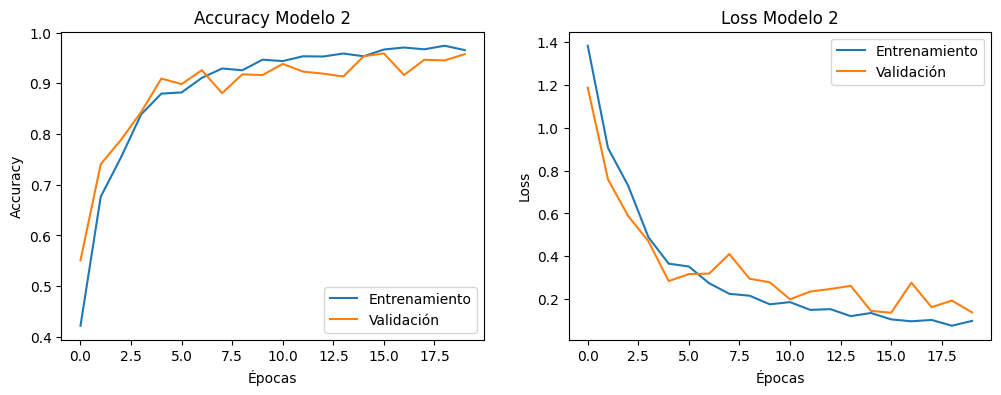


Accuracy validación final (Modelo 2): 0.9574
Loss validación final (Modelo 2): 0.1376

Modelo 2 guardado como cnn_modelo2.h5


In [15]:
# Graficar accuracy y loss del modelo 2
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'], label='Entrenamiento')
plt.plot(history_2.history['val_accuracy'], label='Validación')
plt.title('Accuracy Modelo 2')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_2.history['loss'], label='Entrenamiento')
plt.plot(history_2.history['val_loss'], label='Validación')
plt.title('Loss Modelo 2')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

val_acc = history_2.history['val_accuracy'][-1]
val_loss = history_2.history['val_loss'][-1]

print(f"\nAccuracy validación final (Modelo 2): {val_acc:.4f}")
print(f"Loss validación final (Modelo 2): {val_loss:.4f}")

# Guardar el modelo entrenado
cnn_2.save("cnn_modelo2.h5")
print("\nModelo 2 guardado como cnn_modelo2.h5")

##### Modelo 3

###### Red CNN

In [17]:
# Modelo 3
cnn_3 = Sequential()

# 1ra Capa convolucional + Pooling
cnn_3.add(Conv2D(filters=32, kernel_size=(3,3), activation="relu", input_shape=(64,64,3)))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))

# 2da Capa convolucional + Pooling
cnn_3.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))

# 3ra Capa convolucional + Pooling
cnn_3.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))

# 4ta Capa convolucional + Pooling
cnn_3.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
cnn_3.add(MaxPooling2D(pool_size=(2,2)))

# Aplanar
cnn_3.add(Flatten())

# 1ra capa densa oculta
cnn_3.add(Dense(units=256, activation="relu"))
cnn_3.add(Dropout(0.3))  # regularización

# 2da capa densa oculta
cnn_3.add(Dense(units=128, activation="relu"))
cnn_3.add(Dropout(0.2))

# Capa de salida (6 clases → softmax)
cnn_3.add(Dense(units=6, activation="softmax"))

# Compilar
cnn_3.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Resumen
cnn_3.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,486 (2.61 MB)

 Trainable params: 684,486 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

###### Entrenamiento

In [18]:
history_3 = cnn_3.fit(
    training_set,
    epochs=20,
    validation_data=val_set,
    verbose=1)


Epoch 1/20
67/80 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.2044 - loss: 1.7774

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 24s 239ms/step - accuracy: 0.2118 - loss: 1.7672 - val_accuracy: 0.3929 - val_loss: 1.5098
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 197ms/step - accuracy: 0.3590 - loss: 1.4699 - val_accuracy: 0.5330 - val_loss: 1.1591
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 16s 196ms/step - accuracy: 0.6076 - loss: 1.0772 - val_accuracy: 0.6909 - val_loss: 0.8263
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.7464 - loss: 0.7464 - val_accuracy: 0.8668 - val_loss: 0.4447
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - accuracy: 0.8342 - loss: 0.5227 - val_accuracy: 0.8544 - val_loss: 0.4533
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 0.8699 - loss: 0.4056 - val_accuracy: 0.8283 - val_loss: 0.5057
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.8686 - loss: 0.3877 - val_accuracy: 0.8874 - val_loss: 0.3329
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 17s 213ms/step - accuracy: 0.9016 - loss: 0.3155 - val_accuracy: 0.881

###### GRafica - Resultados

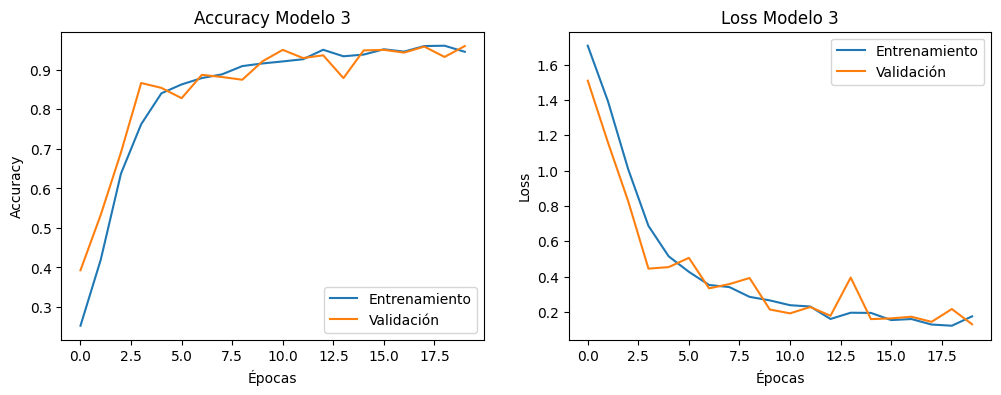


Accuracy validación final (Modelo 3): 0.9602
Loss validación final (Modelo 3): 0.1295

Modelo 3 guardado como cnn_modelo3.h5


In [19]:
# Graficar accuracy y loss del modelo 3
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_3.history['accuracy'], label='Entrenamiento')
plt.plot(history_3.history['val_accuracy'], label='Validación')
plt.title('Accuracy Modelo 3')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_3.history['loss'], label='Entrenamiento')
plt.plot(history_3.history['val_loss'], label='Validación')
plt.title('Loss Modelo 3')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

val_acc = history_3.history['val_accuracy'][-1]
val_loss = history_3.history['val_loss'][-1]

print(f"\nAccuracy validación final (Modelo 3): {val_acc:.4f}")
print(f"Loss validación final (Modelo 3): {val_loss:.4f}")

# Guardar el modelo entrenado
cnn_2.save("cnn_modelo3.h5")
print("\nModelo 3 guardado como cnn_modelo3.h5")

##### Comparación de modelos

In [22]:
# valores finales de cada modelo
acc1, loss1 = history_1.history['val_accuracy'][-1], history_1.history['val_loss'][-1]
acc2, loss2 = history_2.history['val_accuracy'][-1], history_2.history['val_loss'][-1]
acc3, loss3 = history_3.history['val_accuracy'][-1], history_3.history['val_loss'][-1]

# Guardar en tabla
resultados = {
    "Modelo": ["Modelo 1", "Modelo 2", "Modelo 3"],
    "Accuracy Validación": [acc1, acc2, acc3],
    "Loss Validación": [loss1, loss2, loss3]
}

# Crear DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar resultados
print(df_resultados)

# Seleccionar el mejor modelo según accuracy de validación
mejor_modelo = df_resultados.loc[df_resultados["Accuracy Validación"].idxmax()]
print("\nMejor modelo según validación:")
print(mejor_modelo)

     Modelo  Accuracy Validación  Loss Validación
0  Modelo 1             0.956044         0.199662
1  Modelo 2             0.957418         0.137610
2  Modelo 3             0.960165         0.129459

Mejor modelo según validación:
Modelo                 Modelo 3
Accuracy Validación    0.960165
Loss Validación        0.129459
Name: 2, dtype: object


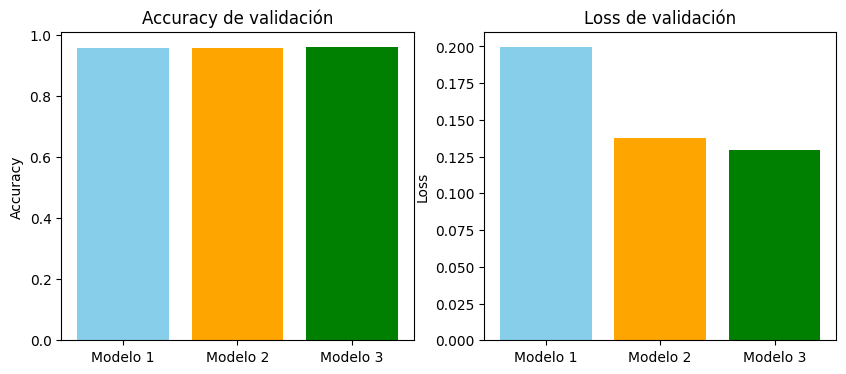

In [23]:
# Comparación accuracy y loss
plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,1)
plt.bar(df_resultados["Modelo"], df_resultados["Accuracy Validación"], color=['skyblue','orange','green'])
plt.title("Accuracy de validación")
plt.ylabel("Accuracy")

# Loss
plt.subplot(1,2,2)
plt.bar(df_resultados["Modelo"], df_resultados["Loss Validación"], color=['skyblue','orange','green'])
plt.title("Loss de validación")
plt.ylabel("Loss")

plt.show()


#### Test al mejor modelo (modelo 3)

 7/12 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Accuracy en Test: 0.94293

Reporte de métricas:
                  precision    recall  f1-score   support

      FreshApple       0.94      0.94      0.94        62
     FreshBanana       0.97      0.97      0.97        63
     FreshCarrot       0.93      0.98      0.95        63
     FreshTomato       0.92      0.89      0.90        61
    RottenPotato       0.94      0.98      0.96        59
RottenStrawberry       0.98      0.90      0.94        60

        accuracy                           0.94       368
       macro avg       0.94      0.94      0.94       368
    weighted avg       0.94      0.94      0.94       368



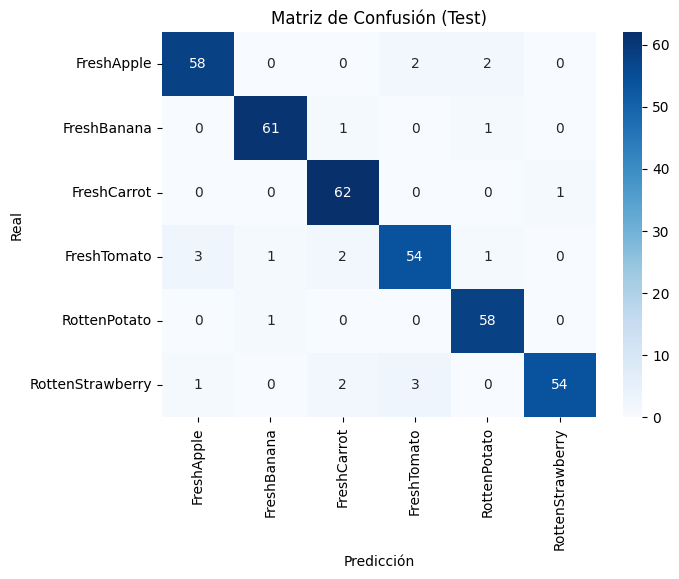

In [27]:
# Predicciones con el modelo 3
y_pred = cnn_3.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)        # clase con mayor probabilidad
y_true = test_set.classes                 # clases reales

# Accuracy global
print("Accuracy en Test:", round(accuracy_score(y_true, y_pred), 5))

# Reporte de métricas
print("\nReporte de métricas:")
print(classification_report(y_true, y_pred, target_names=list(test_set.class_indices.keys())))

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_set.class_indices.keys(),
            yticklabels=test_set.class_indices.keys())
plt.title("Matriz de Confusión (Test)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

### Conclusion

Entre las consideraciones para trabajar con el dataset, se decidió trabajar con imágenes en color en lugar de escala de grises debido a que las frutas y vegetales tienen características visuales muy dependientes del color (por ejemplo, distinguir un tomate fresco de uno podrido, o un banano maduro de uno dañado) a diferencia de animales como gatos o perros que su forma prevalece por sobre el color. Usar escala de grises habría eliminado esa información cromática, reduciendo la capacidad del modelo de capturar patrones importantes (Una naranja puede pasar por tomate o manzana por ejemplo). Aunque en grises se reduce el costo computacional (al tener un solo canal en lugar de tres), en este problema el costo-beneficio favoreció mantener los tres canales de color, además de poder hacer uso del procesamiento de CoLab.

En cuanto a las arquitecturas probadas, se entrenaron tres modelos de CNN con distinta profundidad y configuración. De los modelos, el tercero resultó ser el más eficiente, alcanzando un accuracy de validación de 96.02% y un loss de validación de 0.1295, superando ligeramente al Modelo 2 y de forma más marcada al Modelo 1.

La razón por la que el Modelo 3 funciona mejor que los demás es porque logró un balance adecuado entre profundidad y regularización. Este modelo incorporó más capas convolucionales que permiten extraer características más complejas, y además incluyó capas de Dropout, lo que ayudó a reducir el sobreajuste y mejorar la generalización. En contraste, el Modelo 1 resultó demasiado simple (menor capacidad de aprendizaje), mientras que el Modelo 2, aunque sólido, no incorporaba mecanismos de regularización tan efectivos como el tercero.

Sin embargo tanto el modelo 2 y el 3 tenían un accuracy y loss bastante similares entonces en un entorno en el cual el costo computacional es un factor a tomar en cuenta, el modelo 2 podría ser un candidato a tomar en cuenta y ser utilizado y probablemente daría resultados bastante aceptables. En nuestro caso, al hacer uso de los recursos de CoLab, se decidió ir por el modelo 3.

Durante la fase de test el Modelo 3 mantuvo un desempeño alto y consistente, confirmando que no se trataba de un caso de sobreajuste al conjunto de validación. La matriz de confusión muestra que, aunque el modelo fue bastante preciso en la mayoría de las clases, todavía se produjeron algunas detecciones erróneas (por ejemplo, confusiones entre frutas frescas y en mal estado). Esto refleja que, si bien el modelo captura adecuadamente los patrones cromáticos y estructurales principales, aún existen casos límite donde las características visuales se solapan.

De lo anterior, el Modelo 3 fue la arquitectura más adecuada para resolver este problema, gracias a que combina mayor capacidad de aprendizaje con regularización, logrando capturar patrones visuales relevantes sin perder generalización, y manteniendo un nivel de error bajo y aceptable para la tarea planteada.

Para lograr una mejoría al modelo se podría intentar mayor variaciones en las transformaciones de la Data Augmentatio, incrementar la resolución de las imagenes a 128x128 (se usó 64x64) y variar los hiperparámetros hasta encontrar un punto donde exista una alta predicción sin caer en sobreajuste. (Solo que llevaría un mayor costo computacional)